In [1]:
import h5py
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({
        "axes.linewidth": 2, "xtick.major.width": 2, "ytick.major.width": 2})
import matplotlib.colors as colors

from __future__ import annotations
from pyhipp import plot
from pyhipp.core import DataDict

from pyccb import samples
from pyccb.process.halo_web import HaloWebCross
from pyccb.process import ab_matching
from pyccb.process import calc_zw

SAMPLE_PATH = Path('/Volumes/T7/samples')  # Path in local
# SAMPLE_PATH = Path('/data14/Fhong/halo_web')  # Path in the serve

N_grid = 256

# --- Parameters ---
# Define the paths to your input samples
file_halo_sample = SAMPLE_PATH / 'halo_sample.hdf5'
file_tidal_field = SAMPLE_PATH / f'field_sample_{N_grid}_hr.hdf5'
dir_output = SAMPLE_PATH / 'output'

field = h5py.File(file_tidal_field, 'r', locking=False)
print(field.keys())
halo = h5py.File(file_halo_sample, 'r', locking=False)
print(halo.keys())

numbers = np.array([301, 1599, 1528, 2665])
halo_list = ab_matching(samples.halo.HaloSample.from_file(file_halo_sample), numbers)
zf_bounds = [halo_list[0]['zf'].min()]
for halo in halo_list:
    zf_bounds.append(halo['zf'].max())
    # halo = calc_zw(halo, halo_list[0])

print(zf_bounds)
# 

name_list = ['young', 'adult', 'middle', 'old']

<KeysViewHDF5 ['delta_sm_x', 'l_box', 'lams', 'n_grids', 'web_type']>
<KeysViewHDF5 ['m_peak', 'mass', 'position', 'spin', 'v_peak', 'zf']>
[HaloSample] HaloSample: n_objs=23653, keys=('m_peak', 'mass', 'position', 'spin', 'v_peak', 'zf')
[HaloSample] HaloSample: n_objs=1168, keys=('m_peak', 'mass', 'position', 'spin', 'v_peak', 'zf')
[HaloSample] HaloSample: n_objs=6207, keys=('m_peak', 'mass', 'position', 'spin', 'v_peak', 'zf')
[HaloSample] HaloSample: n_objs=5932, keys=('m_peak', 'mass', 'position', 'spin', 'v_peak', 'zf')
[HaloSample] HaloSample: n_objs=10346, keys=('m_peak', 'mass', 'position', 'spin', 'v_peak', 'zf')
[np.float32(0.023974428), np.float32(0.6446418), np.float32(1.3575766), np.float32(1.7435706), np.float32(5.5297656)]


In [6]:
# 2PCCF computation parameters
lr_range, n_bins = [0.1, 1.2], 8 # log10(r) [Mpc/h], range and number of radial bins
rng_seed = 10086                 # Random seed for reproducibility
n_bootstrap = 100                # Number of bootstrap resamplings for error estimation
mass_weighted = True             # Weight field points by their local density

def find_halo_web_2pccf(halo_sample: samples.halo.HaloSample, 
                        tidal_field: samples.field.TidalField) -> dict:
    hwc = HaloWebCross(
        halo_sample, tidal_field, lr_range=lr_range, n_bins=n_bins, rng=rng_seed)
    lrs = hwc.lrs
    web_types = ['void', 'sheet', 'filament', 'knot']
    ccfs = hwc.corrs(mass_weighted=mass_weighted)['web_typed']
    out = {}
    for ccf, web_type in zip(ccfs, web_types):
        bootstrapped_ccf = hwc.bootstrap(ccf, n_bootstrap)
        median, (lo_1sigma, hi_1sigma) = bootstrapped_ccf.median, bootstrapped_ccf.sigma_1

        out[web_type] = np.column_stack([lrs, median, lo_1sigma, hi_1sigma])
        
    return out

In [7]:
print(f"Loading tidal field from: {file_tidal_field}")
tidal_field = samples.field.TidalField.from_file(file_tidal_field, recon_only=False)

for halo, name in zip(halo_list, name_list):
    print(f"Loading {name} halo sample.")
    out_2pccf = find_halo_web_2pccf(halo, tidal_field)

    header = '''Columns:
    1: log10(r / [h^-1 Mpc]): Center of radial bin
    2: xi(r): Halo-cosmic-web cross-correlation function (median of bootstraps)
    3: 16th percentile of xi(r) from bootstraps
    4: 84th percentile of xi(r) from bootstraps'''

    for web_type, data in out_2pccf.items():
        file_out = dir_output / f'res_hr/{name}_halo_{web_type}_2pccf.txt'
        np.savetxt(file_out, data, header=header, fmt='%.6e')
        print(f"Saved {name} halo 2pccf to {file_out}")
    del web_type, data, out_2pccf


# halo = halo_list[3]
# name = name_list[3]

# print(f"Loading {name} halo sample.")
# out_2pccf = find_halo_web_2pccf(halo, tidal_field)

# header = '''Columns:
# 1: log10(r / [h^-1 Mpc]): Center of radial bin
# 2: xi(r): Halo-cosmic-web cross-correlation function (median of bootstraps)
# 3: 16th percentile of xi(r) from bootstraps
# 4: 84th percentile of xi(r) from bootstraps'''

# for web_type, data in out_2pccf.items():
#     file_out = dir_output / f'{name}_halo_{web_type}_2pccf.txt'
#     np.savetxt(file_out, data, header=header, fmt='%.6e')
#     print(f"Saved {name} halo 2pccf to {file_out}")
# del web_type, data, out_2pccf

Loading tidal field from: /data14/Fhong/halo_web/field_sample_256_hr.hdf5
[TidalField] TidalField: threshold=0.0
[TidalField] All field volume are used.
Loading young halo sample.
Saved young halo 2pccf to /data14/Fhong/halo_web/output/res_hr/young_halo_void_2pccf.txt
Saved young halo 2pccf to /data14/Fhong/halo_web/output/res_hr/young_halo_sheet_2pccf.txt
Saved young halo 2pccf to /data14/Fhong/halo_web/output/res_hr/young_halo_filament_2pccf.txt
Saved young halo 2pccf to /data14/Fhong/halo_web/output/res_hr/young_halo_knot_2pccf.txt
Loading adult halo sample.
Saved adult halo 2pccf to /data14/Fhong/halo_web/output/res_hr/adult_halo_void_2pccf.txt
Saved adult halo 2pccf to /data14/Fhong/halo_web/output/res_hr/adult_halo_sheet_2pccf.txt
Saved adult halo 2pccf to /data14/Fhong/halo_web/output/res_hr/adult_halo_filament_2pccf.txt
Saved adult halo 2pccf to /data14/Fhong/halo_web/output/res_hr/adult_halo_knot_2pccf.txt
Loading middle halo sample.
Saved middle halo 2pccf to /data14/Fhong/ha

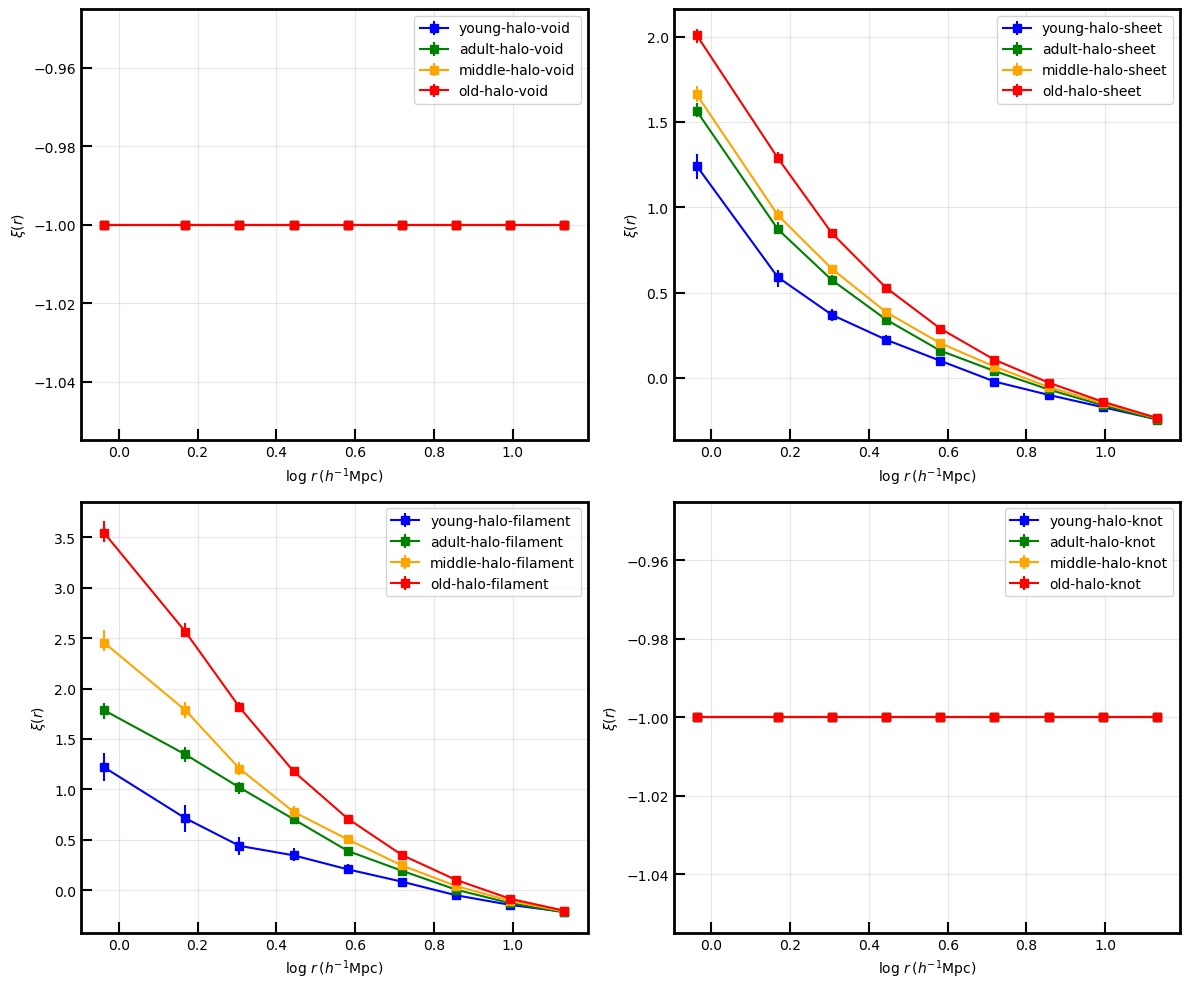

In [2]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({
        "axes.linewidth": 2, "xtick.major.width": 2, "ytick.major.width": 2})
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)
axs = axs.flatten()

web_types = ['void', 'sheet', 'filament', 'knot']
color = ['blue', 'green', 'orange','red']

for i, key in enumerate(web_types):
    ax = axs[i]
    for j, name in enumerate(name_list):
        file_in = f'{dir_output}/res_hr/{name}_halo_{key}_2pccf.txt'
        data = np.loadtxt(file_in)
        x = data[:, 0]
        y = data[:, 1]
        y16 = data[:, 2]
        y84 = data[:, 3]
        yerr = [y - y16, y84 - y]
        ax.errorbar(x, y, yerr=yerr, label=f'{name}-halo-{key}', capsize=0, color=color[j], marker='s', linestyle='-')
    # ax.set_title(key.capitalize())
    ax.set_xlabel(r'$\log\,r\,(h^{-1}\mathrm{Mpc})$')
    ax.set_ylabel(r'$\xi(r)$')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis="both", direction="in", length=8, width=1.5)
    ax.tick_params(which="minor", direction="in", length=3, width=1)
    ax.grid(which="major", alpha=0.3)
    ax.grid(which="minor", alpha=0.1)

plt.tight_layout()
plt.savefig(SAMPLE_PATH / '2pccf_halo_web_hr.png')

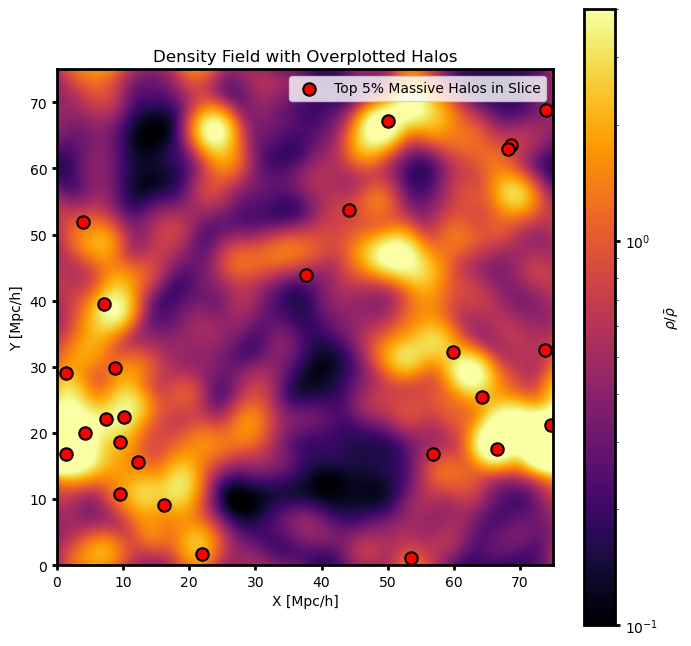

In [25]:
slice_index = 79  # Choose a slice from the middle of the box (0 to 255)
slice_thickness = 5 # Number of slices to average over for a thicker projection

# --- Load Data ---
field_plot = h5py.File(SAMPLE_PATH / f'field_sample_256.hdf5', 'r', locking=False)
delta_sm_x = np.array(field_plot['delta_sm_x'])
l_box = np.array(field_plot['l_box'])
n_grids = np.array(field_plot['n_grids'])

# --- Create Projection ---
# Averaging a few slices can make features clearer
slice_data = np.mean(delta_sm_x[:, :, slice_index : slice_index + slice_thickness], axis=2)

# --- Parameters ---
file_halo_sample = SAMPLE_PATH / 'halo_sample.hdf5'

# --- Load Halo Data ---
with h5py.File(file_halo_sample, 'r', locking=False) as f:
    halo_pos = f['position'][:]
    halo_mass = f['mass'][:]

# Select massive halos to make the plot cleaner
mass_cut = np.quantile(halo_mass, 0.95) # Plot the most massive 5% of halos
massive_halos_pos = halo_pos[halo_mass > mass_cut]

# --- Select halos within the plotted slice ---
z_min = slice_index * l_box / n_grids
z_max = (slice_index + slice_thickness) * l_box / n_grids
in_slice_mask = (massive_halos_pos[:, 2] >= z_min) & (massive_halos_pos[:, 2] < z_max)
halos_in_slice = massive_halos_pos[in_slice_mask]

# --- Plotting (reusing the plot from Method 1) ---
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow((1 + slice_data).T, origin='lower', extent=[0, l_box, 0, l_box],
               cmap='inferno', norm=colors.LogNorm(vmin=0.1, vmax=(1 + delta_sm_x.max())/10))

# Overplot halo positions
ax.scatter(halos_in_slice[:, 0], halos_in_slice[:, 1], 
           edgecolors='black', s=80, lw=1.5, facecolors='red',
           label=f'Top 5% Massive Halos in Slice')

ax.set_title(f'Density Field with Overplotted Halos')
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.legend()
fig.colorbar(im, ax=ax, label=r'$\rho / \bar{\rho}$')
plt.show()
# plt.savefig(SAMPLE_PATH / 'density_field_with_halos.png')

<Figure size 640x480 with 0 Axes>

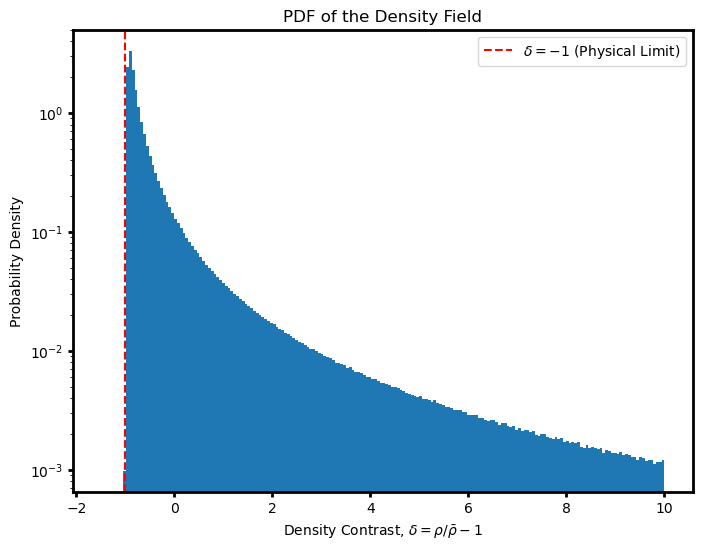

In [10]:
# --- Continuing from the previous cell ---

fig, ax = plt.subplots(figsize=(8, 6))

# Flatten the 3D array to 1D and plot histogram
# We plot delta, not 1+delta
ax.hist(delta_sm_x.flatten(), bins=200, range=(-1.5, 10), log=True, density=True)

ax.axvline(-1, color='red', linestyle='--', label=r'$\delta = -1$ (Physical Limit)')
ax.set_xlabel(r'Density Contrast, $\delta = \rho/\bar{\rho} - 1$')
ax.set_ylabel('Probability Density')
ax.set_title('PDF of the Density Field')
ax.legend()
plt.show()

In [11]:
slice_index = 128  # Choose a slice from the middle of the box (0 to 255)
slice_thickness = 5 # Number of slices to average over for a thicker projection

field_origin = h5py.File('/Volumes/Urchive/gal_web_cross/data/domain.tidal.s99.sm1.hdf5', 'r', locking=False)
delta_sm_x = np.array(field_origin['delta_sm_x'])
l_box = np.array(field_origin['l_box'])
n_grids = np.array(field_origin['n_grids'])

# --- Create Projection ---
# Averaging a few slices can make features clearer
slice_data = np.mean(delta_sm_x[:, :, slice_index : slice_index + slice_thickness], axis=2)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(1 + slice_data, origin='lower', extent=[0, l_box, 0, l_box],
               cmap='inferno', norm=colors.LogNorm(vmin=0.1, vmax=(1 + delta_sm_x.max())/10))


ax.set_title(f'Density Field with Overplotted Halos')
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.legend()
fig.colorbar(im, ax=ax, label=r'$\rho / \bar{\rho}$')
plt.show()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Volumes/Urchive/gal_web_cross/data/domain.tidal.s99.sm1.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)